In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_path = '../input/'
data_train = pd.read_csv(data_path + 'sensor_train/sensor_train.csv')
data_test = pd.read_csv(data_path + 'sensor_test/sensor_test.csv')
data_test['fragment_id'] += 10000
label = 'behavior_id'

In [3]:
data = pd.concat([data_train, data_test], sort=False)

In [4]:
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]

In [5]:
data['acc'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2) ** 0.5
data['accg'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2 + data['acc_zg'] ** 2) ** 0.5

In [6]:
for f in tqdm([f for f in data.columns if 'acc' in f]):
    for stat in ['min', 'max', 'mean', 'median', 'std', 'skew']:
        df[f+'_'+stat] = data.groupby('fragment_id')[f].agg(stat).values

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.50s/it]


In [7]:
train_df = df[df[label].isna()==False].reset_index(drop=True)
test_df = df[df[label].isna()==True].reset_index(drop=True)

drop_feat = []
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]

48
['acc_x_min', 'acc_x_max', 'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_skew', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_skew', 'acc_z_min', 'acc_z_max', 'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_skew', 'acc_xg_min', 'acc_xg_max', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_std', 'acc_xg_skew', 'acc_yg_min', 'acc_yg_max', 'acc_yg_mean', 'acc_yg_median', 'acc_yg_std', 'acc_yg_skew', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_std', 'acc_zg_skew', 'acc_min', 'acc_max', 'acc_mean', 'acc_median', 'acc_std', 'acc_skew', 'accg_min', 'accg_max', 'accg_mean', 'accg_median', 'accg_std', 'accg_skew']


In [8]:
scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.1,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 19,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 4,
    'seed': 2020,
    'max_depth': 10,
    'num_leaves': 64,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}

oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]
for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.105949	valid_1's multi_error: 0.328307
[40]	training's multi_error: 0.0317161	valid_1's multi_error: 0.305003
[60]	training's multi_error: 0.00531459	valid_1's multi_error: 0.289925
[80]	training's multi_error: 0.00154295	valid_1's multi_error: 0.29061
[100]	training's multi_error: 0.00120007	valid_1's multi_error: 0.283071
[120]	training's multi_error: 0.00120007	valid_1's multi_error: 0.278958
[140]	training's multi_error: 0.000514315	valid_1's multi_error: 0.276217
[160]	training's multi_error: 0.000342877	valid_1's multi_error: 0.273475
[180]	training's multi_error: 0.000342877	valid_1's multi_error: 0.273475
[200]	training's multi_error: 0.000342877	valid_1's multi_error: 0.27416
[220]	training's multi_error: 0.000171438	valid_1's multi_error: 0.273475
[240]	training's multi_error: 0.000171438	valid_1's multi_error: 0.268677
[260]	training's multi_error: 0.000171438	valid_1's multi_error: 0

192

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.106635	valid_1's multi_error: 0.342015
[40]	training's multi_error: 0.0334305	valid_1's multi_error: 0.306374
[60]	training's multi_error: 0.00754329	valid_1's multi_error: 0.291981
[80]	training's multi_error: 0.00188582	valid_1's multi_error: 0.287183
[100]	training's multi_error: 0.00102863	valid_1's multi_error: 0.287183
[120]	training's multi_error: 0.000171438	valid_1's multi_error: 0.288554
[140]	training's multi_error: 0.000171438	valid_1's multi_error: 0.285812
[160]	training's multi_error: 0.000171438	valid_1's multi_error: 0.289239
[180]	training's multi_error: 0.000171438	valid_1's multi_error: 0.289239
Early stopping, best iteration is:
[139]	training's multi_error: 0.000171438	valid_1's multi_error: 0.283756


488

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.105245	valid_1's multi_error: 0.320302
[40]	training's multi_error: 0.0320535	valid_1's multi_error: 0.305213
[60]	training's multi_error: 0.00719918	valid_1's multi_error: 0.290809
[80]	training's multi_error: 0.00154268	valid_1's multi_error: 0.281893
[100]	training's multi_error: 0.000342818	valid_1's multi_error: 0.275034
[120]	training's multi_error: 0.000171409	valid_1's multi_error: 0.272977
[140]	training's multi_error: 0.000171409	valid_1's multi_error: 0.26749
[160]	training's multi_error: 0.000171409	valid_1's multi_error: 0.266804
[180]	training's multi_error: 0.000171409	valid_1's multi_error: 0.266118
[200]	training's multi_error: 0.000171409	valid_1's multi_error: 0.268176
[220]	training's multi_error: 0.000171409	valid_1's multi_error: 0.26749
Early stopping, best iteration is:
[176]	training's multi_error: 0.000171409	valid_1's multi_error: 0.263374


552

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.10953	valid_1's multi_error: 0.319616
[40]	training's multi_error: 0.0349674	valid_1's multi_error: 0.29904
[60]	training's multi_error: 0.00617072	valid_1's multi_error: 0.282579
[80]	training's multi_error: 0.00137127	valid_1's multi_error: 0.27915
[100]	training's multi_error: 0.000857045	valid_1's multi_error: 0.273663
[120]	training's multi_error: 0.000342818	valid_1's multi_error: 0.275034
[140]	training's multi_error: 0.000514227	valid_1's multi_error: 0.27572
[160]	training's multi_error: 0.000171409	valid_1's multi_error: 0.270233
[180]	training's multi_error: 0.000171409	valid_1's multi_error: 0.268176
[200]	training's multi_error: 0.000171409	valid_1's multi_error: 0.270233
[220]	training's multi_error: 0	valid_1's multi_error: 0.268176
Early stopping, best iteration is:
[176]	training's multi_error: 0.000171409	valid_1's multi_error: 0.268176


552

Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.112616	valid_1's multi_error: 0.340878
[40]	training's multi_error: 0.0325677	valid_1's multi_error: 0.299726
[60]	training's multi_error: 0.00685636	valid_1's multi_error: 0.282579
[80]	training's multi_error: 0.00171409	valid_1's multi_error: 0.277092
[100]	training's multi_error: 0.000685636	valid_1's multi_error: 0.275034
[120]	training's multi_error: 0.000171409	valid_1's multi_error: 0.269547
[140]	training's multi_error: 0	valid_1's multi_error: 0.26406
[160]	training's multi_error: 0	valid_1's multi_error: 0.264746
[180]	training's multi_error: 0	valid_1's multi_error: 0.263374
Early stopping, best iteration is:
[148]	training's multi_error: 0	valid_1's multi_error: 0.262689


440

In [9]:
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1) / folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

,feat,gain,split
25,acc_yg_max,9355.456782,14224
39,acc_median,8799.601447,10904
24,acc_yg_min,7910.470309,16734
28,acc_yg_std,7166.229267,15212
10,acc_y_std,6494.557421,14498
26,acc_yg_mean,5972.458362,16512
32,acc_zg_mean,5636.713321,17169
44,accg_mean,5529.527941,23771
20,acc_xg_mean,5424.921720,18770
19,acc_xg_max,4925.722524,14545


,feat,gain,split
44,accg_mean,5529.527941,23771
45,accg_median,3625.301158,20763
2,acc_x_mean,2785.699606,20212
8,acc_y_mean,3287.453714,19969
20,acc_xg_mean,5424.921720,18770
14,acc_z_mean,2163.237084,18562
32,acc_zg_mean,5636.713321,17169
41,acc_skew,1677.773258,16780
23,acc_xg_skew,1477.942782,16756
24,acc_yg_min,7910.470309,16734


In [10]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [11]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)

In [12]:
round(accuracy_score(train_y, oof_y), 5)

0.73108

In [13]:
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
round(score, 5)

0.77043

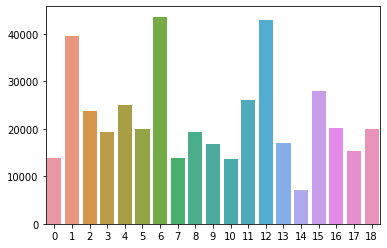

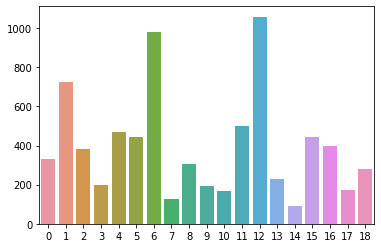

In [14]:
sub = pd.read_csv(data_path+'提交结果示例.csv')

sub['behavior_id'] = labels

vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

In [15]:
sub.to_csv('../sub/sub_%.5f.csv' % score, index=False)